In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from pyjet import cluster
from pyjet import cluster,DTYPE_PTEPM
from pyjet.testdata import get_event
import h5py as h5

In [3]:
outfile = "small_data/small_events_anomalydetection_0.h5"
hf = h5.File(outfile, 'r')
print(hf["data"].keys())

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>


In [5]:
keys = list(hf["data"].keys())


In [7]:
keys = list(hf["data"].keys())
for key in keys:
    print(hf["data"][key])

<HDF5 dataset "axis0": shape (2101,), type "<i8">
<HDF5 dataset "axis1": shape (110000,), type "<i8">
<HDF5 dataset "block0_items": shape (2101,), type "<i8">
<HDF5 dataset "block0_values": shape (110000, 2101), type "<f8">


In [15]:
# Only load the first couple events
size = 10000
df = pd.read_hdf(outfile, "data", stop=size)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(10000, 2101)
Memory in GB: 0.15661120414733887


In [16]:
df.shape

(10000, 2101)

In [127]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
events_combined = df.T

In [128]:
events_combined.shape
events_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.324101,0.646304,0.325172,0.290918,0.526330,0.307490,0.305228,0.550740,0.823849,0.361629,...,22.549061,0.467982,4.432257,0.487591,1.198400,0.256487,0.319303,0.552500,0.338862,0.626047
1,-0.361158,-0.539460,-0.833948,-2.200063,-2.349110,-1.999438,-1.949587,-1.799677,-2.409386,-1.561485,...,-0.525972,-1.993226,-2.325274,-2.307305,-2.155422,-1.719700,-0.770895,-0.881639,-0.868035,-1.238908
2,2.737669,-1.386258,2.404844,1.630132,-1.745532,2.590663,-2.294166,-3.037725,0.120901,2.277365,...,-2.083035,-0.242534,-2.555464,-0.740001,-1.551230,-0.833353,3.106929,2.820565,2.984343,0.505947
3,0.409859,0.471293,1.295058,0.565028,0.542491,0.296564,0.611917,0.497987,0.392440,1.756224,...,6.464812,0.439723,0.326687,2.520947,0.437137,0.874030,0.395848,0.437082,0.661918,0.414505
4,-2.429939,-1.636572,-2.089618,-1.714345,-2.080352,-2.257138,-1.139748,-2.165318,-1.953236,-0.967060,...,-0.523991,-1.169341,-0.661042,-2.320902,-2.142012,-1.453976,-0.760495,-2.356772,-0.647047,-0.594919


In [19]:
leadpT = {}
leadeta = {}
leadphi = {}
leadmass = {}

subleadpT = {}
subleadeta = {}
subleadphi = {}
subleadmass = {}

alljets = {}
N = size # number of events

for mytype in ['background','signal']:
    leadpT[mytype]=[]
    leadeta[mytype]=[]
    leadphi[mytype]=[]
    leadmass[mytype]=[]
    
    subleadpT[mytype]=[]
    subleadeta[mytype]=[]
    subleadphi[mytype]=[]
    subleadmass[mytype]=[]
    
    alljets[mytype]=[]

    for i in tqdm(range(N)):
        issignal = events_combined[i][2100] # signal flag
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
             continue
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM) # nontrivial particles in event i
        for j in range(700):
            if (events_combined[i][j*3]>0):
                pseudojets_input[j]['pT'] = events_combined[i][j*3]
                pseudojets_input[j]['eta'] = events_combined[i][j*3+1]
                pseudojets_input[j]['phi'] = events_combined[i][j*3+2]
            else:
                break

        sequence = cluster(pseudojets_input, R=1.0, p=-1) # jet_algos: -1 = anti-kt, 1 = kt, 0 = cambridge-aachen
        jets = sequence.inclusive_jets(ptmin=1200)
        
        if len(jets) > 1:
            leadpT[mytype] += [jets[0].pt]
            leadeta[mytype] += [jets[0].eta]
            leadphi[mytype] += [jets[0].phi]
            leadmass[mytype] += [jets[0].mass]
            subleadpT[mytype] += [jets[1].pt]
            subleadeta[mytype] += [jets[1].eta]
            subleadphi[mytype] += [jets[1].phi]
            subleadmass[mytype] += [jets[1].mass]
            alljets[mytype] += [jets]
        pass

100%|██████████| 10000/10000 [00:03<00:00, 2983.84it/s]


In [20]:
bg_lead = np.array([leadpT['background'],leadeta['background'],leadphi['background'],leadmass['background']])
bg_sublead = np.array([subleadpT['background'],subleadeta['background'],subleadphi['background'],subleadmass['background']])
signal_lead = np.array([leadpT['signal'],leadeta['signal'],leadphi['signal'],leadmass['signal']])
signal_sublead = np.array([subleadpT['signal'],subleadeta['signal'],subleadphi['signal'],subleadmass['signal']])


In [197]:
background = pd.DataFrame(data=np.concatenate((bg_lead,bg_sublead)).T, columns=["pt1", "eta1","phi1","m1","pt2", "eta2","phi2","m2"])
background.head()

,pt1,eta1,phi1,m1,pt2,eta2,phi2,m2
0,1286.727685,0.185508,-2.763676,106.912129,1283.220733,0.064989,0.393688,63.164215
1,1354.394070,0.826505,1.365524,614.269108,1325.613761,-0.874319,-1.786248,439.064150
2,1285.227873,0.328693,2.975321,516.835248,1220.251279,0.294854,-0.322661,174.796077
3,1443.428208,-0.687846,-2.586448,129.683023,1409.761077,-0.165983,0.560043,132.533394
4,1381.327250,0.306355,0.815522,296.615532,1319.182982,-0.856785,-2.389302,313.871471


In [198]:
signal = pd.DataFrame(data=np.concatenate((signal_lead,signal_sublead)).T, columns=["pt1", "eta1","phi1","m1","pt2", "eta2","phi2","m2"])
signal.head()

,pt1,eta1,phi1,m1,pt2,eta2,phi2,m2
0,1787.625573,-0.934612,1.185407,99.168898,1717.649940,-1.044915,-1.955165,515.054419
1,1368.776255,-1.136360,1.353935,104.840764,1283.549433,0.053019,-1.781479,452.024576
2,1659.355146,-0.348487,2.475010,110.390275,1634.435917,0.102619,-0.649581,487.949083
3,1827.270115,0.208524,-0.979991,551.510487,1799.302155,-0.452693,2.177153,108.942106
4,1534.930051,0.456967,2.489777,113.748193,1299.176369,1.244766,-0.588482,474.705286


In [21]:
print(bg_lead.shape)
print(bg_sublead.shape)
print(signal_lead.shape)
print(signal_sublead.shape)

(4, 5647)
(4, 5647)
(4, 818)
(4, 818)


In [148]:
pt1 = signal_lead[0,:]
pt2 = signal_sublead[0,:]
eta1 = signal_lead[1,:]
eta2 = signal_sublead[1,:]
phi1 = signal_lead[2,:]
phi2 = signal_sublead[2,:]
m1 = signal_lead[3,:]
m2 = signal_sublead[3,:]

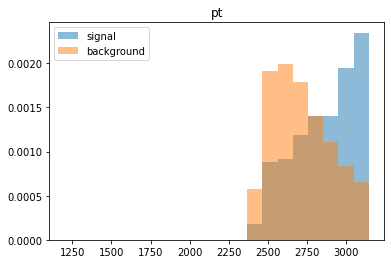

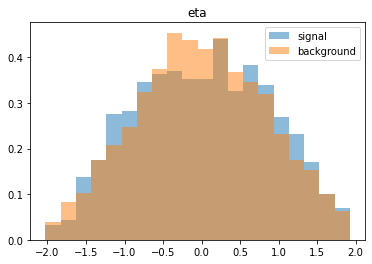

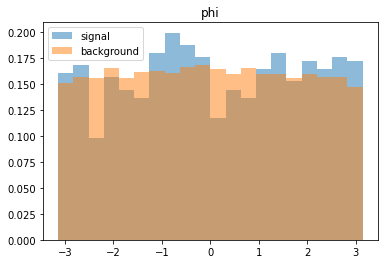

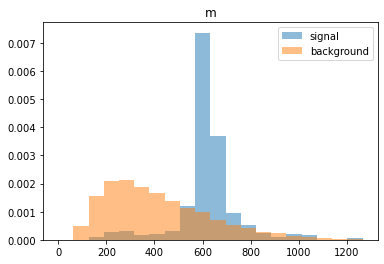

In [192]:
features = ['pt','eta','phi','m']
for i in range(len(features)):
    r = (min(np.concatenate((signal_lead[i,:],signal_sublead[i,:],bg_lead[i,:],bg_sublead[i,:]))), max(np.concatenate((signal_lead[i,:],signal_sublead[i,:],bg_lead[i,:],bg_sublead[i,:]))))
    plt.hist(signal_lead[i,:]+signal_sublead[i,:], alpha = 0.5, label = "signal", density = True, bins = 20, range = r)
    plt.hist(bg_lead[i,:] + bg_sublead[i,:], alpha = 0.5, label = "background", density = True, bins = 20, range = r)
    plt.title(features[i])
    plt.legend()
    plt.show()

In [27]:
E1 = np.sqrt(m1**2 + (pt1**2) * (np.cosh(eta1)**2))
E2 = np.sqrt(m2**2 + (pt2**2) * (np.cosh(eta2)**2))

In [131]:
def plot2hist(data1,data2,title,bins = 20):
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,6)
    ax1.set_title(title)
    ax1.hist(data1, bins,alpha = 0.5, label = "leading_jet " + title)
    ax1.hist(data2,bins, alpha = 0.5, label = "subjet " + title)
    ax1.legend()
    ax2.set_title(title + " of leading vs. subleading jet")
    ax2.set_xlabel("Leading jet " + title)
    ax2.set_ylabel("Subleading jet" + title)
    ax2.hist2d(data1, data2, bins, cmap="BuPu")
    plt.show()

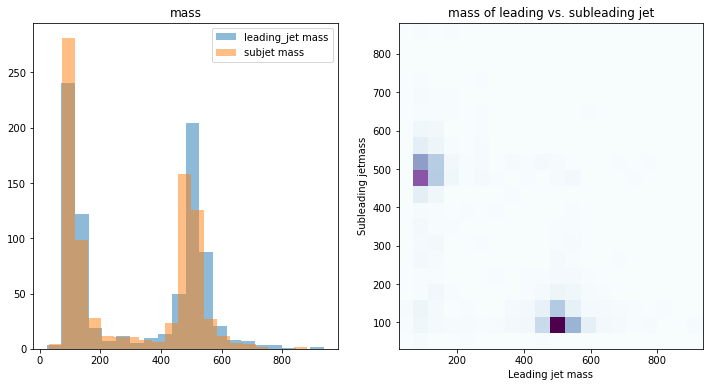

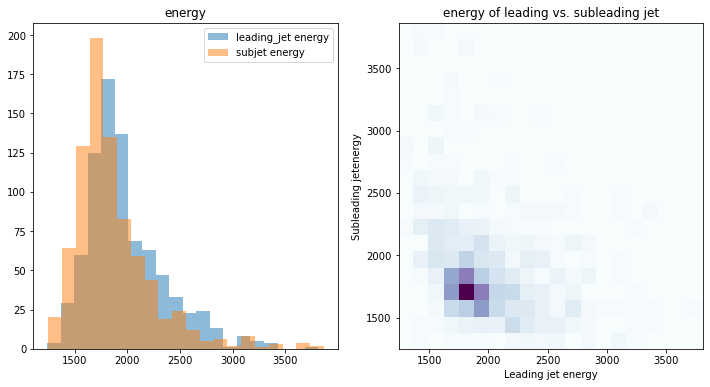

In [162]:
plot2hist(m1,m2,"mass")
plot2hist(E1,E2,"energy")

In [224]:
def CalcDeltaR(j1, j2):
    eta1 = j1.eta1
    phi1 = j1.phi1
    eta2 = j2.eta2
    phi2 = j2.phi2

    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)


    dR = (dPhi**2 + dEta**2)**0.5

    return dR

(array([0.00908535, 0.04542674, 0.13628021, 0.3089018 , 3.83401644,
        1.6807892 , 0.97213213, 0.35432853, 0.07268278, 0.01817069]),
 array([2.56066129, 2.69521795, 2.8297746 , 2.96433125, 3.09888791,
        3.23344456, 3.36800121, 3.50255787, 3.63711452, 3.77167117,
        3.90622783]),
 <BarContainer object of 10 artists>)

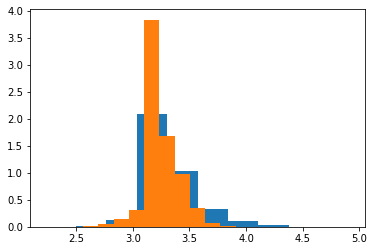

In [228]:
plt.hist(CalcDeltaR(background.iloc[:,:4],background.iloc[:,4:]), density = True)
plt.hist(CalcDeltaR(signal.iloc[:,:4],signal.iloc[:,4:]), density = True)


,pt1,eta1,phi1,m1
0,1286.727685,0.185508,-2.763676,106.912129
1,1354.394070,0.826505,1.365524,614.269108
2,1285.227873,0.328693,2.975321,516.835248
3,1443.428208,-0.687846,-2.586448,129.683023
4,1381.327250,0.306355,0.815522,296.615532
...,...,...,...,...
5642,1579.606336,0.381834,-0.707099,411.373352
5643,1592.768272,0.309251,1.348882,105.309154
5644,1232.481760,0.604169,-0.885644,147.413416
5645,2088.472687,0.343663,2.916831,352.674725
